In [1]:
# example derived from /home/woody/caph/mpp228/ML/CTA/dl1-data-handler_stage1/notebooks/dl1reading_stage1.ipynb
# conda activate dl1dh_s1
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import time
import sys
sys.path.append("../../") # go to parent dir
import iact_dnn_utils as utils
import tables as tb

from dl1_data_handler.reader import DL1DataReaderSTAGE1, DL1DataReaderDL1DH

In [2]:
import importlib
importlib.reload(utils)

<module 'iact_dnn_utils' from '/home/woody/caph/mpp228/ML/iact_dnn/general/noteobooks/../../iact_dnn_utils.py'>

In [3]:
cdict = {'mode':'mono',
         'tel':'MST_MST_FlashCam',
         #'tel':'LST_LST_LSTCam',
        'Etrue_min':0.3,
         #'Etrue_min':None,
        'n_events':10**5,
         'n_events_tot':10**6,
         'folder_dl1':'/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/\
Prod5_Paranal_AdvancedBaseline_NSB1x_EventPlaceholder_North_20deg_ctapipe_v0.10.5_DL1/',
         'folder_square': '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/',
         'event_type':'electron' # 'proton', 'gamma-diffuse', 'electron'
        }

In [4]:
test = False
if test:
    cdict['n_events'] = 1000
    cdict['n_events_tot'] = 2000
    
event_type = cdict['event_type'] # 'proton', 'gamma-diffuse', 'electron'
evt = event_type.split('-')[0]
mode = cdict['mode'] # 'mono', 'stereo'
if mode == 'mono':
    ntels = 1
    #LSTcams = [2]
    #LSTcams = [1, 2, 3, 4]
    selected_telescope_types = [cdict['tel']]
else:
    ntels = 4 # generalize in the future - for now these are the four LSTs
    #LSTcams = [1, 2, 3, 4]
    selected_telescope_types = [cdict['tel']]
    

Etrue_min = cdict['Etrue_min']
if Etrue_min is not None:
    event_selection = [{'col_name': "true_energy", 'min_value':Etrue_min}]
else:
    event_selection = None

#n_events = 1000 #10**4
n_events = cdict['n_events'] # events per file
n_events_tot = cdict['n_events_tot'] # total number of events
print(n_events, mode)

#folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
#folder_in = folder + 'Prod5_Paranal_AdvancedBaseline_NSB1x_%s_North_20deg_ctapipe_v0.10.5_DL1/' % event_type
folder_in = cdict['folder_dl1'].replace('EventPlaceholder', event_type)
fns = os.listdir(folder_in)
fns = [fn for fn in fns if fn.endswith('h5')]
print(fns[0])

folder_out = cdict['folder_square']
if not os.path.isdir(folder_out):
    os.mkdir(folder_out)
    
fn_out = folder_out + utils.get_square_images_fn(cdict)

print(folder_in)
print(fn_out)

channels_list = ['image', 'image_mask', 'peak_time',]
tel_pars_list = ['obs_id', 'event_id', 'tel_id', 
            'hillas_intensity', 'hillas_x', 'hillas_y', 'hillas_width', 'hillas_length',
            'hillas_psi', 'hillas_skewness', 'hillas_kurtosis', 'hillas_r', 'hillas_phi',
            'morphology_num_pixels', 'morphology_num_medium_islands', 'morphology_num_large_islands',
            'leakage_pixels_width_1', 'leakage_pixels_width_2', 
            'leakage_intensity_width_1', 'leakage_intensity_width_2',
            'intensity_mean'] # tel parameters in cta-pipe .h5
if mode == 'stereo':
    tel_pars_list_extra = ['tel_trigger'] # tel parameters in cta-pipe .h5
else:
    tel_pars_list_extra = []
mc_info_list = ["true_energy", "true_alt", "true_az"] # mc parameters
groups = ['mc_pars', 'tel_pars', 'tel_pars_extra']

print(channels_list, tel_pars_list, mc_info_list)

def fn2reader(fn, mode='mono'):
    return DL1DataReaderSTAGE1([fn],
                             mode=mode,
                             #example_identifiers_file="./examples.h5",
                             selected_telescope_types=selected_telescope_types,
                             #selected_telescope_ids={"LST_LST_LSTCam": LSTcams},
                             #image_channels = ['image', 'peak_time', 'image_mask'],
                             image_channels=channels_list,
                             parameter_list=tel_pars_list,
                             event_info=mc_info_list,
                             event_selection=event_selection)

100000 mono
electron_20deg_0deg_run1398___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5
/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_electron_North_20deg_ctapipe_v0.10.5_DL1/
/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/electron_100000_images_mono_Etrue_min0.3TeV_MST_MST_FlashCam.h5
['image', 'image_mask', 'peak_time'] ['obs_id', 'event_id', 'tel_id', 'hillas_intensity', 'hillas_x', 'hillas_y', 'hillas_width', 'hillas_length', 'hillas_psi', 'hillas_skewness', 'hillas_kurtosis', 'hillas_r', 'hillas_phi', 'morphology_num_pixels', 'morphology_num_medium_islands', 'morphology_num_large_islands', 'leakage_pixels_width_1', 'leakage_pixels_width_2', 'leakage_intensity_width_1', 'leakage_intensity_width_2', 'intensity_mean'] ['true_energy', 'true_alt', 'true_az']


In [5]:
out_dict = {key:{} for key in groups}
for key in mc_info_list:
    out_dict['mc_pars'][key] = np.zeros(n_events)
for key in tel_pars_list:
    out_dict['tel_pars'][key] = np.zeros((n_events, ntels))
for key in tel_pars_list_extra:
    out_dict['tel_pars_extra'][key] = np.zeros((n_events, ntels))

In [6]:
if test:
    fn = folder_in + fns[0]
    reader = fn2reader(fn, mode=mode)
    print(len(reader), mode)
    if mode == 'mono':
        print(reader[0][0].shape)
    else:
        print(reader[0][1].shape)


In [7]:
# there seems to be memory leakage in DL1DH: it cannot read more than about 500 files
# one needs to write the last filenumber for input and output here and restart the kernel
# the calculation will start with these files + 1
# for the initial run put i = -1, out_file_number = 0
if event_type == 'proton':
    i = 205
    out_file_number = 10
elif event_type == 'gamma-diffuse':
    i = 115
    out_file_number = 7
elif event_type == 'electron':
    i = 48
    out_file_number = 3

nout = 0
nout_tot = 0
finish = False

In [8]:
%%time
t0 = time.time()
t_read = 0.

if mode == 'mono':
    i0 = 0
else:
    i0 = 1

i += 1
while nout_tot < n_events_tot or finish:
    fn = folder_in + fns[i]
    t_read0 = time.time()
    
    skip = False
    try:
        reader = fn2reader(fn, mode=mode)
    except tb.NoSuchNodeError:
        print('problem with file:')
        print(fn)
        print('skipping it\n')
        skip = True
        #break
        #finish = True
    except:
        print('problem with file:')
        print(fn)
        print(i)
        break
        #finish = True
        
    if not skip:
        t_read += time.time() - t_read0
        if 'image' not in out_dict:
            im_dims = reader[0][i0].shape[i0:i0+2]
            for key in channels_list:
                if mode == 'stereo':
                    out_dict[key] = np.zeros((n_events, im_dims[0], im_dims[1], ntels), dtype=np.float32)
                else:
                    out_dict[key] = np.zeros((n_events, im_dims[0], im_dims[1]), dtype=np.float32)
        for k in range(len(reader)):
            if nout + k == n_events:
                nout_tot += n_events
                nout = -k
                out_file_number += 1
                fn_out_running = fn_out.replace('.h5', '_file%i.h5' % out_file_number)
                if test:
                    fn_out_running = fn_out_running.replace('.h5', '_test.h5')
                if os.path.isfile(fn_out_running):
                    os.remove(fn_out_running)
                with h5py.File(fn_out_running, 'w') as h5_out:
                    for key in out_dict.keys():
                        if key in h5_out:
                            del h5_out[key]
                        if key in groups:
                            h5_out.create_group(key)
                            for vkey in out_dict[key].keys():
                                h5_out[key][vkey] = out_dict[key][vkey]
                        else:
                            h5_out[key] = out_dict[key]
                print('write %i events to file:' % n_events)
                print('i = %i' %i)
                print(fn_out_running)

            #out_dict['images'][nout + k] = reader[k][0][:,:,0]

            if mode == 'stereo':
                trigger = reader[k][0][:]
            if channels_list:
                images = reader[k][i0][:]
            if tel_pars_list:
                pars = reader[k][i0+1].T
            if mc_info_list:
                mc_pars = reader[k][i0+2:i0+2+len(mc_info_list)]

            for m, key in enumerate(channels_list):
                if mode == 'mono':
                    out_dict[key][nout + k] = images[:,:,m]
                else:
                    out_dict[key][nout + k] = np.transpose(images.T[m], (1,0,2))
            for m, key in enumerate(tel_pars_list):
                out_dict['tel_pars'][key][nout + k] = pars[m]
            for m, key in enumerate(mc_info_list):
                out_dict['mc_pars'][key][nout + k] = mc_pars[m]
            for key in tel_pars_list_extra:
                if key == 'tel_trigger' and mode == 'stereo':
                    out_dict['tel_pars_extra'][key][nout + k] = trigger
        nout += len(reader)
        del reader
    i += 1
    if i == len(fns):
        break
    if i % 10 == 0 or test:
        print('%i files, %i events, %.2f s to read, %.2f s past' % 
              (i, (nout_tot + nout), t_read, time.time() - t0))
    


10 files, 61817 events, 60.88 s to read, 274.03 s past
write 100000 events to file:
i = 16
/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/electron_100000_images_mono_Etrue_min0.3TeV_MST_MST_FlashCam_file1.h5
20 files, 125093 events, 92.56 s to read, 557.65 s past
30 files, 186947 events, 123.76 s to read, 810.32 s past
write 100000 events to file:
i = 32
/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/electron_100000_images_mono_Etrue_min0.3TeV_MST_MST_FlashCam_file2.h5
40 files, 248315 events, 156.24 s to read, 1101.06 s past
write 100000 events to file:
i = 48
/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/electron_100000_images_mono_Etrue_min0.3TeV_MST_MST_FlashCam_file3.h5
50 files, 308516 events, 192.58 s to read, 1408.25 s past


KeyboardInterrupt: 

In [9]:
test

False

In [10]:
if 1:
    fn_test2 = folder_in + fns[i]
    print(fn_test2)
    reader = fn2reader(fn_test2, mode=mode)
    #del reader
    if 0:
        try:
            reader = fn2reader(fn_test2, mode=mode)
        except:
            print('skip')

/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_electron_North_20deg_ctapipe_v0.10.5_DL1/electron_20deg_0deg_run1127___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5


In [11]:
len(fns)

379

In [12]:
test_output = 1
if test_output:
    with h5py.File(fn_out_running, 'r') as h5_test:
        print(h5_test.keys())
        print(h5_test['tel_pars'].keys())
        print(h5_test['image'].shape)
        tel_ids = np.array(h5_test['tel_pars']['tel_id'], dtype=int)


<KeysViewHDF5 ['image', 'image_mask', 'mc_pars', 'peak_time', 'tel_pars', 'tel_pars_extra']>
<KeysViewHDF5 ['event_id', 'hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi', 'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x', 'hillas_y', 'intensity_mean', 'leakage_intensity_width_1', 'leakage_intensity_width_2', 'leakage_pixels_width_1', 'leakage_pixels_width_2', 'morphology_num_large_islands', 'morphology_num_medium_islands', 'morphology_num_pixels', 'obs_id', 'tel_id']>
(100000, 112, 112)


(array([3488., 3473., 3471., 3495., 3724., 3811., 3786., 3730., 3673.,
        3708., 3678., 3685., 3730., 3697., 3776., 3763., 3636., 3422.,
        3356., 3458., 3482., 3396., 3396., 3397.]),
 array([ 4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5,
        15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5,
        26.5, 27.5, 28.5]),
 <BarContainer object of 24 artists>)

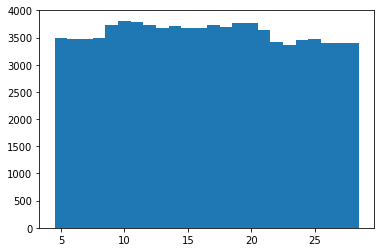

In [13]:
#tel_ids = tel_ids[:,0]
plt.hist(tel_ids, bins=np.arange(4.5, 29.5, 1))

In [14]:
if test:
    if 'image' in out_dict:
        plt.imshow(out_dict['image'][0,:,:,0])

In [15]:
if test:
    with h5py.File(fn_out_running, 'r') as h5_test:
        plt.imshow(h5_test['image'][0,:,:,0])

In [16]:
if test:
    with h5py.File(fn_out_running, 'r') as h5_test:
        plt.imshow(h5_test['image_mask'][0,:,:,0])

In [17]:
if test:
    h5_test = h5py.File(fn_out_running, 'r')

In [18]:
if test:
    for i in range(5):
        EE = h5_test['mc_pars']['true_energy'][i]
        hi = h5_test['tel_pars']['hillas_intensity'][i]
        hx = h5_test['tel_pars']['hillas_x'][i]
        print('%i, Energy %.3f' % (i, EE))
        print('hillas intensity %s' % hi)
        print('hillas x %s' % hx)


In [19]:
if test:
    i = 9
    xi = 110 * (1 + h5_test['tel_pars']['hillas_x'][i]) / 2
    yi = 110 * (1 + h5_test['tel_pars']['hillas_y'][i]) / 2
    plt.plot(xi, yi, marker='s')

In [20]:
if test:
    h5_test.close()

In [21]:
if test:
    # remove test files
    for fn in os.listdir(folder_out):
        if fn.find('_test.h5') > 0:
            os.remove(folder_out + fn)